## Birth Rate Analysis

Dataset: NCHS - Births and Birth Rates Data
https://www.kaggle.com/cdc/nchs-births-and-birth-rates-data

#### Convert Data into TimeSeries

In [1]:
# import required libraries
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
warnings.simplefilter("ignore")
%matplotlib inline
sns.set_style("white")

In [2]:
birth = pd.read_csv('data/births.csv')
birth.head()

,year,month,day,gender,births
0,1969,1,1.0,F,4046
1,1969,1,1.0,M,4440
2,1969,1,2.0,F,4454
3,1969,1,2.0,M,4548
4,1969,1,3.0,F,4548


In [3]:
birth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15547 entries, 0 to 15546
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    15547 non-null  int64  
 1   month   15547 non-null  int64  
 2   day     15067 non-null  float64
 3   gender  15547 non-null  object 
 4   births  15547 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 607.4+ KB


Here, we can see that 'day' column contains null-values. This essentially means that there was no data available for that day. In such a case we can set the number of births that day as 0. \
Also, we can see that the 'day' column is float64 type (which is not correct). We need to change this to int.

In [4]:
birth['day'].fillna(0, inplace=True)
birth['day'] = birth['day'].astype(np.int64)
print(birth.head())
birth.info()

   year  month  day gender  births
0  1969      1    1      F    4046
1  1969      1    1      M    4440
2  1969      1    2      F    4454
3  1969      1    2      M    4548
4  1969      1    3      F    4548
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15547 entries, 0 to 15546
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   year    15547 non-null  int64 
 1   month   15547 non-null  int64 
 2   day     15547 non-null  int64 
 3   gender  15547 non-null  object
 4   births  15547 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 607.4+ KB


There is a problem with the dataset. The columns year, month, day constitute for one single timeseries data, with number of births as another feature classified based on gender. \
An easy way to deal with this data, is to broaden the view to decade level, by aggregating the total number of births.

In [5]:
birth['decade'] = 10 * (birth['year'] // 10)
birth.pivot_table('births', index='decade', columns='gender', aggfunc='sum')
birth.head()

,year,month,day,gender,births,decade
0,1969,1,1,F,4046,1960
1,1969,1,1,M,4440,1960
2,1969,1,2,F,4454,1960
3,1969,1,2,M,4548,1960
4,1969,1,3,F,4548,1960


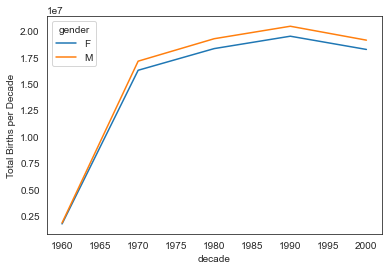

In [6]:
birth_decade = birth.pivot_table('births', index='decade', columns='gender', aggfunc='sum')
birth_decade.plot()
plt.ylabel('Total Births per Decade')
plt.show()

### More EDA:

We can perform more EDA on the dataset by cleaning the data, removing outliers, removing mistyped dates, etc. \
There are many ways to do this, however, we can use a robust sigma-clipping operation for this

In [7]:
birth.describe()

,year,month,day,births,decade
count,15547.000000,15547.000000,15547.000000,15547.000000,15547.000000
mean,1979.037435,6.515919,17.221265,9762.293561,1974.544285
std,6.728340,3.449632,15.357008,28552.465810,6.789583
min,1969.000000,1.000000,0.000000,1.000000,1960.000000
25%,1974.000000,4.000000,8.000000,4358.000000,1970.000000
50%,1979.000000,7.000000,16.000000,4814.000000,1970.000000
75%,1984.000000,10.000000,24.000000,5289.500000,1980.000000
max,2008.000000,12.000000,99.000000,199622.000000,2000.000000


In [8]:
quartiles = np.percentile(birth['births'], [25, 50, 75])
mu = quartiles[1]
sig = 0.74 * (quartiles[2] - quartiles[0])

In [9]:
# now we can use the query method to filter out data outside this range
birth = birth.query('(births > @mu - 5* @sig) & (births < @mu + 5* @sig)')
# also we need to reformat the dataset and convert the discrete features into a continous timeseries feature
birth['day'] = birth['day'].astype(np.int64)
birth.index = pd.to_datetime(10000 * birth.year +
                            100 * birth.month +
                            birth.day, format='%Y%m%d')
birth.head()

,year,month,day,gender,births,decade
1969-01-01,1969,1,1,F,4046,1960
1969-01-01,1969,1,1,M,4440,1960
1969-01-02,1969,1,2,F,4454,1960
1969-01-02,1969,1,2,M,4548,1960
1969-01-03,1969,1,3,F,4548,1960


Now that we can converted our data into a continous timeseries data, we can look at the births on a weekly basis

            year  month  day gender  births  decade  dayofweek
1969-01-01  1969      1    1      F    4046    1960          2
1969-01-01  1969      1    1      M    4440    1960          2
1969-01-02  1969      1    2      F    4454    1960          3
1969-01-02  1969      1    2      M    4548    1960          3
1969-01-03  1969      1    3      F    4548    1960          4


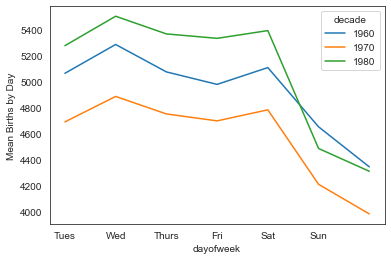

In [10]:
birth['dayofweek'] = birth.index.dayofweek
print(birth.head())

# we can label these dayofweek and plot the birth data
birth.pivot_table('births', index='dayofweek',
                 columns='decade', aggfunc='mean').plot()
plt.gca().set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.ylabel('Mean Births by Day');
plt.show()

Interesting view here, we can see more births during weekdays rather than weekends. \
Alternatively, we can plot the birth rate per year

#### Plot Yearly Birth Rate Curve

In [11]:
birth_month = birth.pivot_table('births', [birth.index.month, birth.index.day])
print(birth_month)

birth_month.index = [pd.datetime(2020, month, day) for (month, day) in birth_month.index]
print(birth_month.head())

         births
1  1   4009.225
   2   4247.400
   3   4500.900
   4   4571.350
   5   4603.625
...         ...
12 27  4850.150
   28  5044.200
   29  5120.150
   30  5172.350
   31  4859.200

[366 rows x 1 columns]
              births
2020-01-01  4009.225
2020-01-02  4247.400
2020-01-03  4500.900
2020-01-04  4571.350
2020-01-05  4603.625


Now, we have data in timeseries format as day-month combination. We can plot this data.

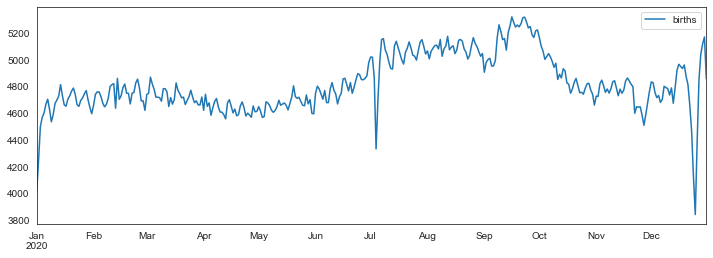

In [12]:
fig, ax = plt.subplots(figsize=(12, 4))
birth_month.plot(ax=ax)
plt.show()

##### If you enjoyed this notebook, consider following me on GitHub!